In [7]:
import os
import sys
from time import time
import numpy as np
import random
import argparse
import torch
import torch.nn as nn
from torch.autograd import Variable
from utils.vocab import Vocab
from data.loader import DataLoader
from utils import torch_utils, scorer, constant, helper

vocab_file = 'saved_models/00/vocab.pkl'
vocab = Vocab(vocab_file, load=True)

label_to_id = constant.LABEL_TO_ID
id_to_label = {v: k for k, v in label_to_id.items()}

deprel_to_id = constant.DEPREL_TO_ID
id_to_deprel = {v: k for k, v in deprel_to_id.items()}

parser = argparse.ArgumentParser()
parser.add_argument('--data_dir', type=str, default='dataset/tacred')
parser.add_argument('--batch_size', type=int, default=64, help='Training batch size.')
parser.add_argument('--word_dropout', type=float, default=0, help='The rate at which randomly set a word to UNK.')
parser.set_defaults(lower=False)
args = parser.parse_args([])
opt = vars(args)

def unpack_batch(batch):
    inputs = [Variable(b) for b in batch[:11]]
    labels = Variable(batch[11])
    tokens = batch[0]
    head = batch[5]
    subj_pos = batch[6]
    obj_pos = batch[7]
    lens = batch[1].eq(0).long().sum(1).squeeze()
    return inputs, labels, tokens, head, subj_pos, obj_pos, lens

train_batch = DataLoader(opt['data_dir'] + '/train.json', opt['batch_size'], opt, vocab, evaluation=True)
dev_batch = DataLoader(opt['data_dir'] + '/dev.json', opt['batch_size'], opt, vocab, evaluation=True)
test_batch = DataLoader(opt['data_dir'] + '/test.json', opt['batch_size'], opt, vocab, evaluation=True)

Vocab size 53953 loaded from file
1065 batches created for dataset/tacred/train.json
354 batches created for dataset/tacred/dev.json
243 batches created for dataset/tacred/test.json


In [8]:
# init calculate
train_cal = dict()
dev_cal = dict()
test_cal = dict()
for i in range(42):
    train_cal[i] = 0
    dev_cal[i] = 0
    test_cal[i] = 0

In [11]:
for batch in dev_batch:
    inputs, labels, tokens, head, subj_pos, obj_pos, lens = unpack_batch(batch)
    for lb in labels:
        dev_cal[int(lb)] += 1

In [57]:
train_base = 0
for i in train_cal.values():
    train_base += i
    
for i in train_cal.keys():
    train_cal[i] = train_cal[i]/train_base

In [58]:
train_cal[0] = 0

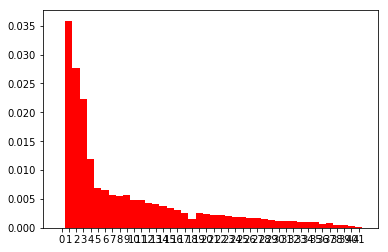

In [61]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

pos = np.arange(len(train_cal.keys()))

width = 1.0     # gives histogram aspect to the bar diagram

ax = plt.axes()
ax.set_xticks(list(train_cal.keys()))
ax.set_xticklabels(train_cal.keys())

plt.bar(train_cal.keys(), train_cal.values(), width, color='r')

plt.show()

In [29]:
import pygraphviz as pgv
G=pgv.AGraph(strict=False,directed=True)
import itertools

In [63]:
import itertools

TARGET = 18

for batch in itertools.islice(test_batch, 15):
    inputs, labels, tokens, head, subj_pos, obj_pos, lens = unpack_batch(batch)
    words, masks, pos, ner, deprel, head, subj_pos, obj_pos, subj_type, obj_type, piece_pos = inputs
    lens = (masks.data.cpu().numpy() == 0).astype(np.int64).sum(1)
    
    for i, wd in enumerate(words):
        G.node_attr['shape']='box'
        G.edge_attr['color']='black'
        G.graph_attr['rankdir'] = 'LR'

        if int(labels[i]) == 0:
            continue
        wd_list = vocab.unmap(wd.int().tolist())
        dep_list = deprel[i].tolist()
        hd_list = head[i].tolist()
        
        fig_path = './saved_models/parser/test/' + str(int(labels[i]))
        helper.ensure_dir(fig_path)
        
        for j in range(lens[i]-1):
            s = str(j) + '_' + wd_list[j]
            t = str(j+1) + '_' + wd_list[j+1]
            G.add_edge(s, t, color='black')
            
        for j in range(lens[i]):
            k = int(head[i][j]) - 1
            if k == -1:
                continue
            s = str(j) + '_' + wd_list[j]
            t = str(k) + '_' + wd_list[k]
            rel = str(int(deprel[i][j])) + '_' + id_to_deprel[int(deprel[i][j])]
            if int(deprel[i][j]) == TARGET:
                G.add_edge(s, t, color='red', label=rel)
            else:
                G.add_edge(s, t, color='blue', label=rel)

        filename = '_'.join(wd_list[:6])
        G.layout(prog='dot')
        G.draw(fig_path + '/' + filename + '.png')
        G.clear()

Directory ./saved_models/parser/test/2 do not exist; creating...
Directory ./saved_models/parser/test/5 do not exist; creating...
Directory ./saved_models/parser/test/6 do not exist; creating...
Directory ./saved_models/parser/test/16 do not exist; creating...
Directory ./saved_models/parser/test/22 do not exist; creating...
Directory ./saved_models/parser/test/1 do not exist; creating...
Directory ./saved_models/parser/test/9 do not exist; creating...
Directory ./saved_models/parser/test/35 do not exist; creating...
Directory ./saved_models/parser/test/11 do not exist; creating...
Directory ./saved_models/parser/test/8 do not exist; creating...
Directory ./saved_models/parser/test/25 do not exist; creating...
Directory ./saved_models/parser/test/4 do not exist; creating...
Directory ./saved_models/parser/test/18 do not exist; creating...
Directory ./saved_models/parser/test/3 do not exist; creating...
Directory ./saved_models/parser/test/20 do not exist; creating...
Directory ./saved_